In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, CubicSpline, interp1d
from scipy.optimize import curve_fit
import time
import scipy


from openparticle.hamiltonians.free_hamiltonians import free_boson_Hamiltonian, free_fermion_Hamiltonian
from openparticle.hamiltonians.yukawa_hamiltonians import *
from openparticle.hamiltonians.renormalized_yukawa_hamiltonian import *
from openparticle.utils import *
from openparticle.dlcq import get_sector_basis, pdf, fock_sector_budget
from yukawa_utils import *

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')

In [96]:
def sliced_basis(resolution, basis, res_slice):

    sliced = []

    for state in basis:
        k1 = state.f_occ[0]
        k2 = state.f_occ[1]
        if k1 + 1/2 >= resolution/2 - res_slice - 1/2 and k2 + 1/2 <= resolution/2 + res_slice + 1/2:
            sliced.append(state)


    return sliced


In [2]:
def nonrelativistic_yukawa(g, mf, mb):
    # Parameters
    N = 100  # Number of grid points
    x_max = 20 # Maximum x value (adjust as needed)
    x_min = -20
    dx = (x_max-x_min)/N
    x = np.linspace(x_min, x_max, N+1)
    V = -g**2 / (2 * mb) * np.exp(-mb * np.abs(x))

    c = 1 ** 2 / ( mf * dx ** 2)
    hamiltonian = np.zeros((N+1, N+1))
    for i in range(1, N - 1):
        hamiltonian[i, i] = 2 * c + V[i]
        hamiltonian[i, i + 1] = -c
        hamiltonian[i, i - 1] = -c
    eigenvalues, eigenvectors = np.linalg.eig(hamiltonian)
    return eigenvalues[eigenvalues < 0]

In [204]:
# print("***** |f⟩ + |fb⟩ Basis *****")
# for res in f_fb_basis:
#     print("--- K = ", res, " ---")

#     basis = (
#         get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 0)
#         + get_sector_basis(resolution = res, n_fermions = 1, n_antifermions = 0, n_bosons = 1)
#     )   
#     hamiltonian = renormalized_yukawa_hamiltonian(
#             res=int(res + 1/2), t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
#         )

#     tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
#     vals = np.linalg.eigvalsh(tmp_mat)
#     print(min(vals))
#     eigenvalues_f_fb_basis.append(min(vals))

In [3]:
g = 1
mf = 1
mb = 0.5

In [4]:
t = 1e-11
eigenvalues_f_fb_basis = []
eigenvalues_ff_ffb_basis = []
eigenstates = []

max_K = 22

f_fb_basis = np.arange(1/2, max_K, 2)
ff_ffb_basis = np.arange(4, max_K + 1, 2)


print("***** |ff⟩ + |ffb⟩ Basis *****")
for res in ff_ffb_basis:
    print("--- K = ", res, " ---")

    basis = (
        get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
        + get_sector_basis(resolution = res, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
    )  

    hamiltonian = renormalized_yukawa_hamiltonian(
            res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
        )
    
    tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
    vals, vecs = np.linalg.eigh(tmp_mat)
    print(min(vals))
    number_of_eigenstates = len(basis)
    eigenvalues_ff_ffb_basis.append(min(vals))
    


***** |ff⟩ + |ffb⟩ Basis *****
--- K =  4  ---
20.35478327182174
--- K =  6  ---
14.00029829474556
--- K =  8  ---
10.922581187715194
--- K =  10  ---
9.070283630420962
--- K =  12  ---
7.820725153499521
--- K =  14  ---
6.915576735027581
--- K =  16  ---
6.226854641022893
--- K =  18  ---
5.683597484710281
--- K =  20  ---
5.24319540879865
--- K =  22  ---
4.877866076333051


In [8]:
def l(x, a, b, c):
    return a + b/x + c/(x**2)

params = curve_fit(l, ff_ffb_basis, eigenvalues_ff_ffb_basis)

In [11]:
l(np.inf, *params[0])

1.4889570835516293

Text(0, 0.5, '$M^2$')

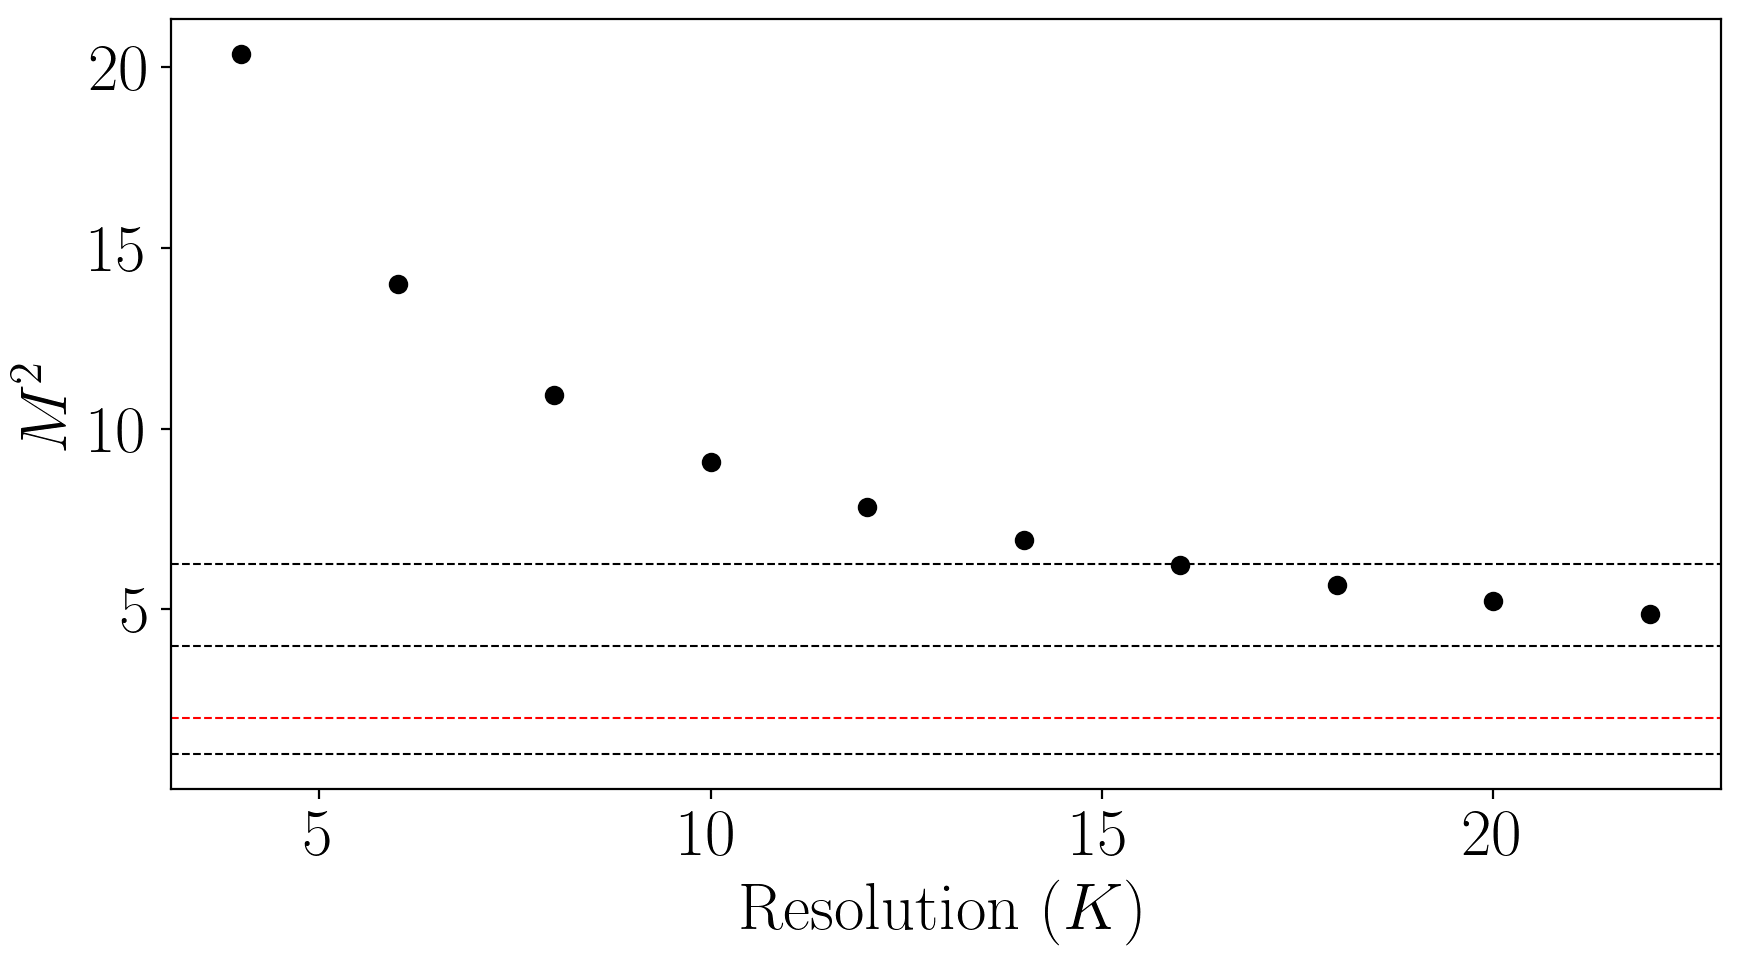

In [10]:
plt.figure(figsize=(10,5), dpi=200)

xnew = np.arange(0, max(ff_ffb_basis), 0.01)
# plt.plot(f_fb_basis, eigenvalues_f_fb_basis, 'ko')
# for i, eig in enumerate(padded_eigenvalues):
#     plt.scatter(ff_ffb_basis, eig, color = 'black', marker = "_", s = 100)
plt.plot(ff_ffb_basis, eigenvalues_ff_ffb_basis, 'ko')
# plt.plot(xnew, l(1/xnew, *params[0]))

plt.axhline(y=mf**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(g, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', linestyle = '--', linewidth = 0.75)
# plt.axhline(y=100, color='white')
plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")



In [ ]:
basis = (
    get_sector_basis(resolution = 33, n_fermions = 2, n_antifermions = 0, n_bosons = 0)
    + get_sector_basis(resolution = 33, n_fermions = 2, n_antifermions = 0, n_bosons = 1)
)  

hamiltonian = renormalized_yukawa_hamiltonian(
        res=res, t=t, treg=0, g=g, mf=mf, mb=mb, verbose=False
    )

tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
vals, vecs = np.linalg.eigh(tmp_mat)
print(min(vals))
number_of_eigenstates = len(basis)
eigenvalues_ff_ffb_basis.append(min(vals))
    


In [300]:
def l(x, a, b, c):
    return a + b/x + c/(x**2)

cut = 0

params = curve_fit(l, ff_ffb_basis, eigenvalues_ff_ffb_basis)
l(np.inf, *params[0])

Text(0, 0.5, '$M^2$')

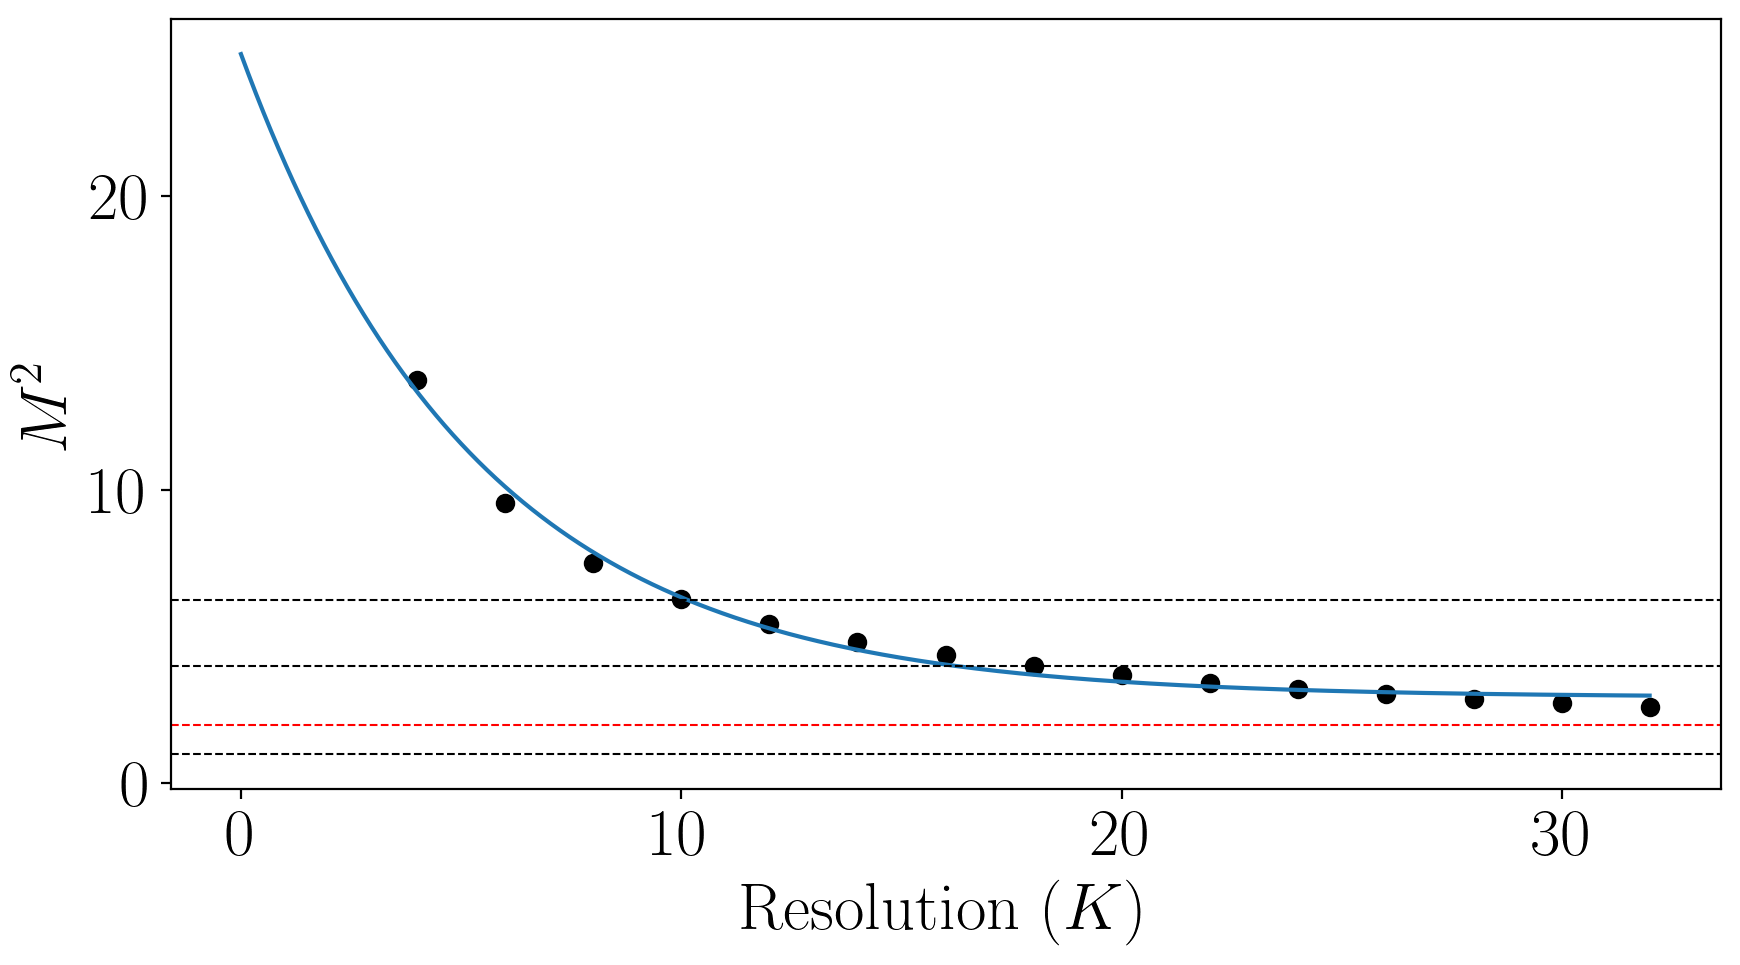

In [299]:
plt.figure(figsize=(10,5), dpi=200)

xnew = np.arange(0, max(ff_ffb_basis), 0.01)
# plt.plot(f_fb_basis, eigenvalues_f_fb_basis, 'ko')
# for i, eig in enumerate(padded_eigenvalues):
#     plt.scatter(ff_ffb_basis, eig, color = 'black', marker = "_", s = 100)
plt.plot(ff_ffb_basis, eigenvalues_ff_ffb_basis, 'ko')
plt.plot(xnew, l(xnew, *params[0]))

plt.axhline(y=mf**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf)**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=(2*mf + mb)**2, color='k', linestyle = '--', linewidth = 0.75)
plt.axhline(y=min(nonrelativistic_yukawa(g, mf, mb)) * 2*2*mf + (2*mf)**2, color='r', linestyle = '--', linewidth = 0.75)
# plt.axhline(y=100, color='white')
plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")



In [326]:
(2*mf + mb)**2

6.25

In [329]:
eigenstate = 0

psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)


fermion_pdf = pdf(res, psi, 'fermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])

In [303]:
fermion_pdf, boson_pdf

(array([7.13065134e-03+0.j, 7.28485771e-03+0.j, 7.81632879e-03+0.j,
        8.68549746e-03+0.j, 9.79322859e-03+0.j, 1.10850710e-02+0.j,
        1.26305420e-02+0.j, 1.46976100e-02+0.j, 1.79840995e-02+0.j,
        2.42853816e-02+0.j, 3.82067350e-02+0.j, 7.08807516e-02+0.j,
        1.43932307e-01+0.j, 2.68758484e-01+0.j, 3.21034392e-01+0.j,
        7.83028516e-02+0.j, 9.29511872e-02+0.j, 3.46345436e-01+0.j,
        2.80905490e-01+0.j, 1.40791051e-01+0.j, 5.91528428e-02+0.j,
        2.32529425e-02+0.j, 8.88906920e-03+0.j, 3.33695965e-03+0.j,
        1.22549800e-03+0.j, 4.34902071e-04+0.j, 1.46089616e-04+0.j,
        4.49534665e-05+0.j, 1.19875007e-05+0.j, 2.48763126e-06+0.j,
        3.07931934e-07+0.j, 6.94732405e-09+0.j]),
 array([2.25451809e-02+0.j, 2.29227942e-02+0.j, 1.78780330e-02+0.j,
        1.38708255e-02+0.j, 1.18605447e-02+0.j, 1.10494246e-02+0.j,
        1.06593551e-02+0.j, 1.02935556e-02+0.j, 9.82620146e-03+0.j,
        9.25149465e-03+0.j, 8.58323848e-03+0.j, 7.78398607e-03+0.j

In [292]:
def f(x, a, b, c):
    return a * np.exp(-(x - c)**2 / b)

fermion_fit_params = curve_fit(f, x_fermion, fermion_pdf)
boson_fit_params = curve_fit(f, x_boson, boson_pdf)

In [3]:
yukawa_hamiltonian(res = 2, mf = 1, g = 1, mb = 1)

1.0000000000000002 * a1^ a1
2.0000000000000004 * a0^ a0
1.3333333333333341 * d1^ d1
4.000000000000001 * d0^ d0
4.000000000000001 * b0^ b0
1.3333333333333341 * b1^ b1
1.5045055561273506 * d0^ d1 a0^
0.531923040535244 * b0 d1 a1^
1.5045055561273506 * d1^ d0 a0
-0.531923040535244 * b1 d0 a1^
-0.531923040535244 * b0^ d1^ a1
1.5045055561273506 * b0^ b1 a0^
0.531923040535244 * b1^ d0^ a1
1.5045055561273506 * b1^ b0 a0
0.11253953951963837 * b1 d1 a1^ a0^
-0.09003163161571068 * d0^ d1 a1^ a0
-0.06820926132509807 * d1^ d1 a1^ a1
-0.11253953951963837 * b1 d1 a0^ a1^
-0.15915494309189543 * b0 d1 a0^ a0^
0.19098593171027456 * d1^ d1 a0^ a0
-0.010610329539459692 * d0^ d0 a1^ a1
0.15915494309189543 * b1 d0 a0^ a0^
-0.10610329539459695 * d0^ d0 a0^ a0
-0.09003163161571068 * d1^ d0 a0^ a1
-0.09003163161571068 * b0^ b1 a1^ a0
-0.010610329539459692 * b0^ b0 a1^ a1
-0.10610329539459695 * b0^ b0 a0^ a0
0.15915494309189543 * b0^ d1^ a0 a0
-0.06820926132509807 * b1^ b1 a1^ a1
0.19098593171027456 * b1^ b1 a0

Text(0, 0.5, '$f(x)$')

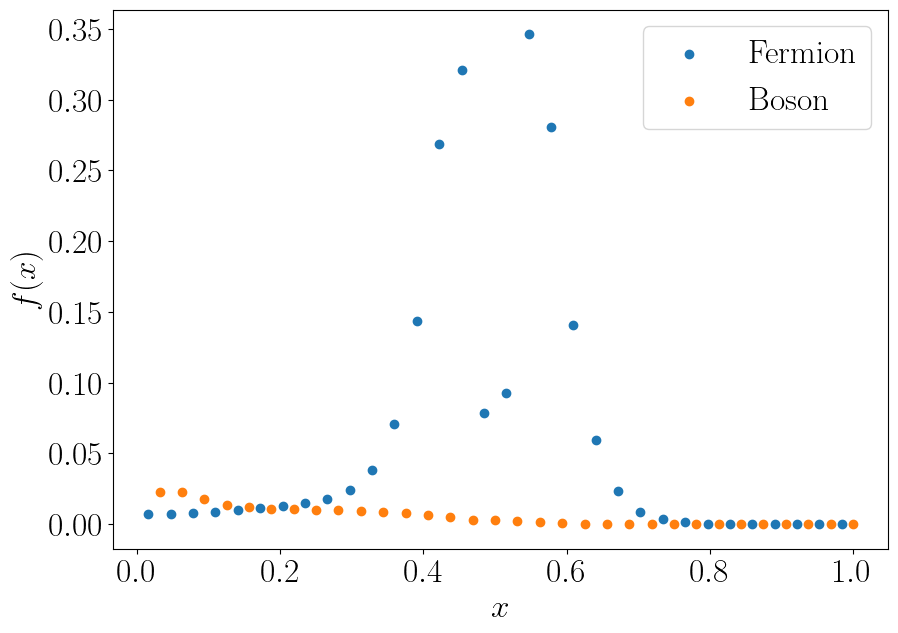

In [330]:
xnew = np.arange(0, 1, 0.001)

plt.figure(figsize = (10, 7), dpi = 100)

plt.scatter(x_fermion, np.real(fermion_pdf), label = f'Fermion')
# plt.plot(xnew, f(xnew, *fermion_fit_params[0]))

plt.scatter(x_boson, np.real(boson_pdf), label = f'Boson')
# plt.plot(xnew, f(xnew, *boson_fit_params[0]))
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

In [231]:
y_data = [eigenvalues_ff_ffb_basis[i] - eigenvalues_ff_ffb_basis[i + 1] for i in range(len(eigenvalues_ff_ffb_basis) - 1)]

In [233]:
def h(x,a,b):
    return a * x + b

params = curve_fit(h, np.log(ff_ffb_basis[1:-1]), np.log(y_data[1:]))


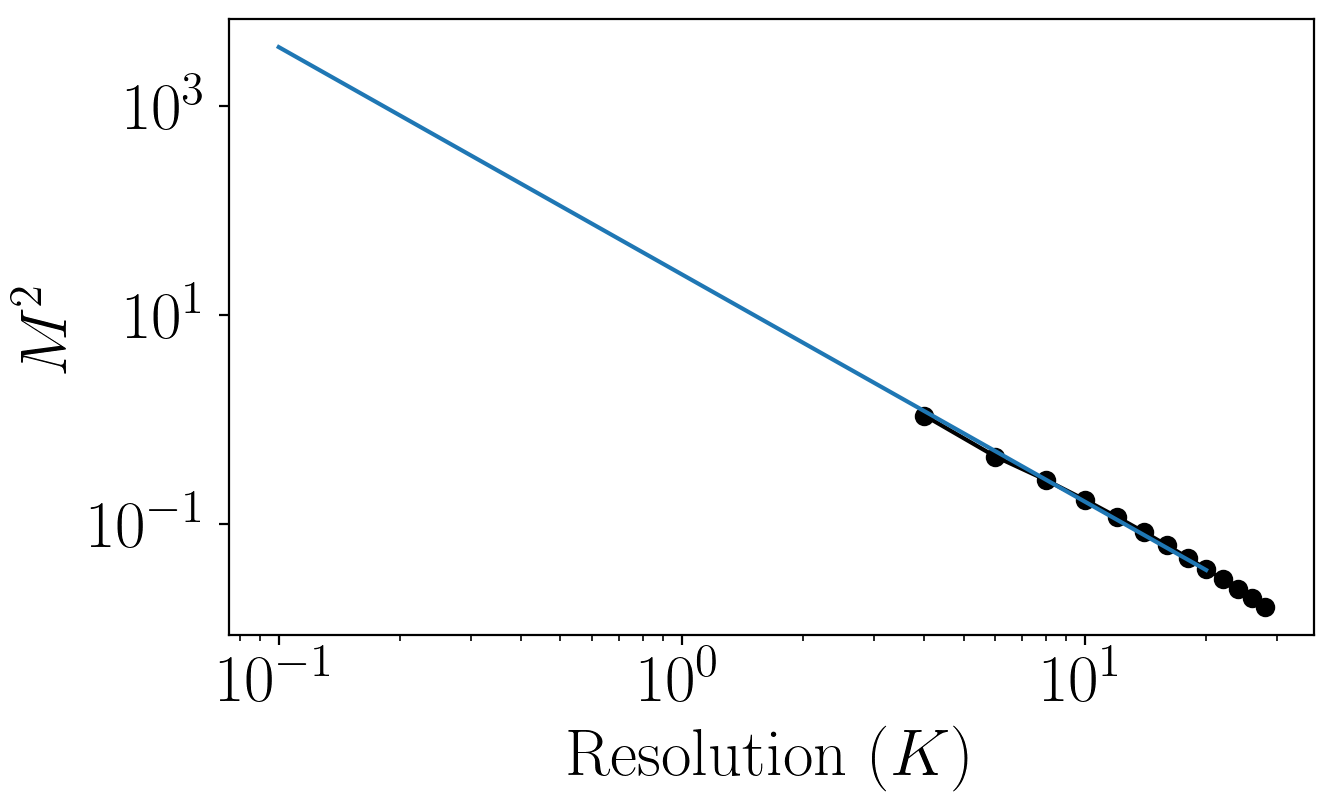

In [239]:
plt.figure(figsize=(7,4), dpi=200)
colors = plt.cm.viridis(np.linspace(0, 1, padded_eigenvalues.shape[0]))

plt.plot(ff_ffb_basis[:-1], y_data, 'ko-')

plt.xlabel(r"Resolution $(K)$")
plt.ylabel(r"$M^2$")

plt.plot(np.arange(0.1, 20, 0.01), np.exp(h(np.log(np.arange(0.1, 20, 0.01)), *params[0])))

# plt.axhline(y = mf**2, linestyle = '--', linewidth = 0.5)
# plt.axhline(y = 4*mf**2, linestyle = '--', linewidth = 0.5)
# y1 = (2 * mf + 0 * mb)**2
# y2 = (2 * mf + 1 * mb)**2
# y0 = (0 * mf + 1 * mb)**2

# plt.axhline(y=y1, color='k', linestyle='--', linewidth=0.5, label=r"$4m_f^2$")
# plt.axhline(y=y2, color='k', linestyle='--', linewidth=0.5, label=r"$\left(2m_f + m_b \right)^2$")
# plt.axhline(y=y0, color='k', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1, 20)
# plt.ylim(3, 100)
# plt.grid()
# plt.savefig('../renormalized_spectrum.pdf', bbox_inches='tight')


Text(0, 0.5, '$xf(x)$')

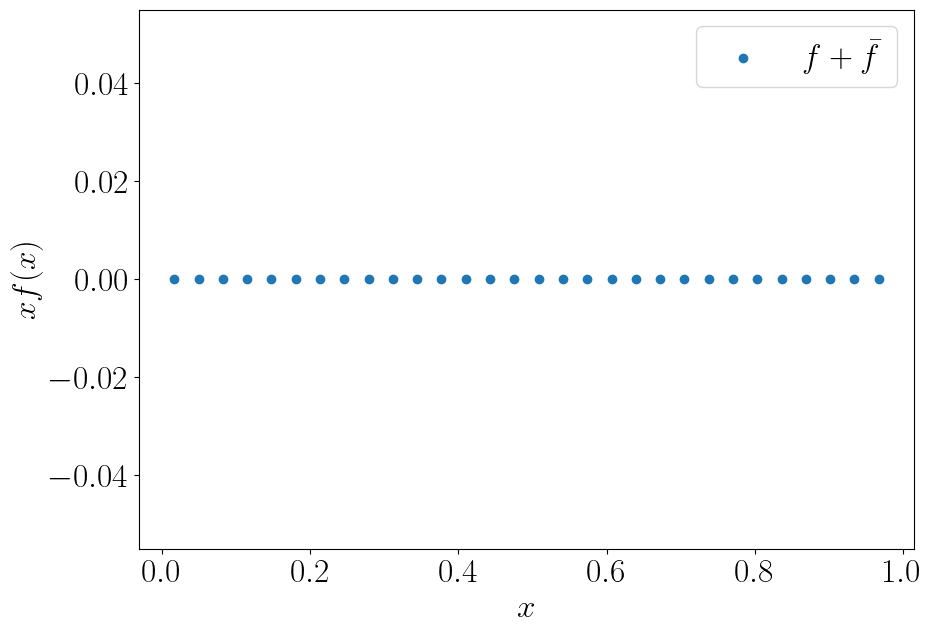

In [8]:
eigenstate = 0

psi = numpy_to_fock(vecs[:, eigenstate], basis)
max_weight, _ = max_fock_weight(psi)


fermion_pdf = pdf(res, psi, 'fermion')
antifermion_pdf = pdf(res, psi, 'antifermion')
boson_pdf = pdf(res, psi, 'boson')

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])


plt.figure(figsize = (10, 7), dpi = 100)

if np.allclose(fermion_pdf, antifermion_pdf):
    plt.scatter(x_fermion, 2 * x_fermion * np.real(fermion_pdf), label = r'$f+ \bar{f}$')

else:
    plt.scatter(x_fermion, x_fermion * np.real(fermion_pdf), label = f'Fermion')
# plt.scatter([], [], color = 'white', label = f'{max_weight}')
plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")

In [34]:
def f(x, a, b, c):
    return a + b/x + c/(x**2)

cut = 0

params = curve_fit(f, resolutions[cut:], grounds[cut:])
f(np.inf, *params[0])

-0.04286954186546672

In [23]:
grounds_bare = np.array([5.33333333, 3.50673873, 3.30318466, 3.21390856, 3.15959835,
       3.12139441])
params_bare = curve_fit(f, resolutions[cut:], grounds_bare[cut:])

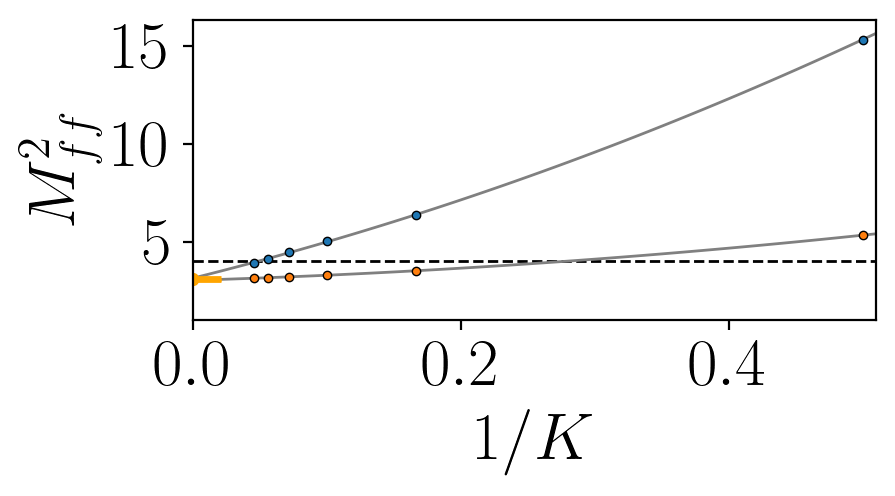

In [24]:
plt.figure(figsize=(5,3), dpi=200)
ks = np.arange(0, 1/(cut + 1), 0.01)
plt.scatter(1/np.array(resolutions)[cut:], grounds[cut:], marker = '.', edgecolors = 'black', zorder = 2, linewidth = 0.5)
plt.scatter(1/np.array(resolutions)[cut:], grounds_bare[cut:], marker = '.', edgecolors = 'black', zorder = 2, linewidth = 0.5)
plt.plot(ks, f(1/ks, *params[0]), color = 'grey', linewidth = 1, zorder = 1)
plt.plot(ks, f(1/ks, *params_bare[0]), color = 'grey', linewidth = 1, zorder = 1)


x = 0
y = f(np.inf, *params[0])
yerr = np.sqrt(np.diag(params[1]))[0]

ybare = f(np.inf, *params_bare[0])
yerrbare = np.sqrt(np.diag(params_bare[1]))[0]

plt.axhline(y = 4*mf**2,color='k', linestyle='--', linewidth=1, zorder = 0)

plt.errorbar(x, y, yerr=yerr, fmt='.', color = 'orange', capsize=10, label=f"{y.round(3)}")
plt.errorbar(x, ybare, yerr=yerrbare, fmt='.', color = 'orange', capsize=10, label=f"{y.round(3)}")


plt.ylabel(r'$M^2_{ff}$')
plt.xlabel(f'$1/K$')
# plt.legend(loc = 'lower right')
plt.xlim(0, 0.01 + 1/(resolutions[0]))
# plt.xticks([0, 0.1, 0.2])
# plt.yscale('log')
plt.ylim(1, 1 + grounds[cut])
plt.tight_layout()
# plt.savefig('../extrapolated_mass.pdf', bbox_inches='tight')

In [588]:
max_res = 22
mf = 1
mb = 0.6
g = 0.5
t = 1e-7


basis = (
    get_Q_nonzero_sector_basis(resolution=max_res, n_fermions = 2, n_bosons = 0)
    + get_Q_nonzero_sector_basis(resolution=max_res, n_fermions = 2, n_bosons = 1)
)

resolutions = [max_res]
renormalized_eigenvalues, renormalized_eigenvectors = get_renormalized_eigenstates(resolutions, t = t, g = g, 
                                                                                   mf = mf, mb = mb,
                                                                                   basis = basis,
                                                                                   return_focks = True, 
                                                                                   num_eigenstates = 'all',
                                                                                   verbose = True, 
                                                                                   assert_positivity = False)

---K =  22 ---
Time of renormalized_yukawa_second_order_form_factor: 13.499462127685547
Time of boson_exchange: 12.341511964797974
Time of fermion_exchange: 20.02972412109375
Time of fermion_self_energy (with loop): 0.04312396049499512
Time of antifermion_self_energy (with loop): 0.041090965270996094
Time of boson_self_energy (with loop): 0.03787493705749512
Size of Hamiltonian: 97143
Hamiltonian generated in: 47.47466993331909
Generating 121 x 121 Matrix...
Matrix generated in: 378.00645875930786
Calculating eigenvalues...
Eigenvalues calculated in: 0.09400773048400879
Time to 'Fockify': 3.373878002166748


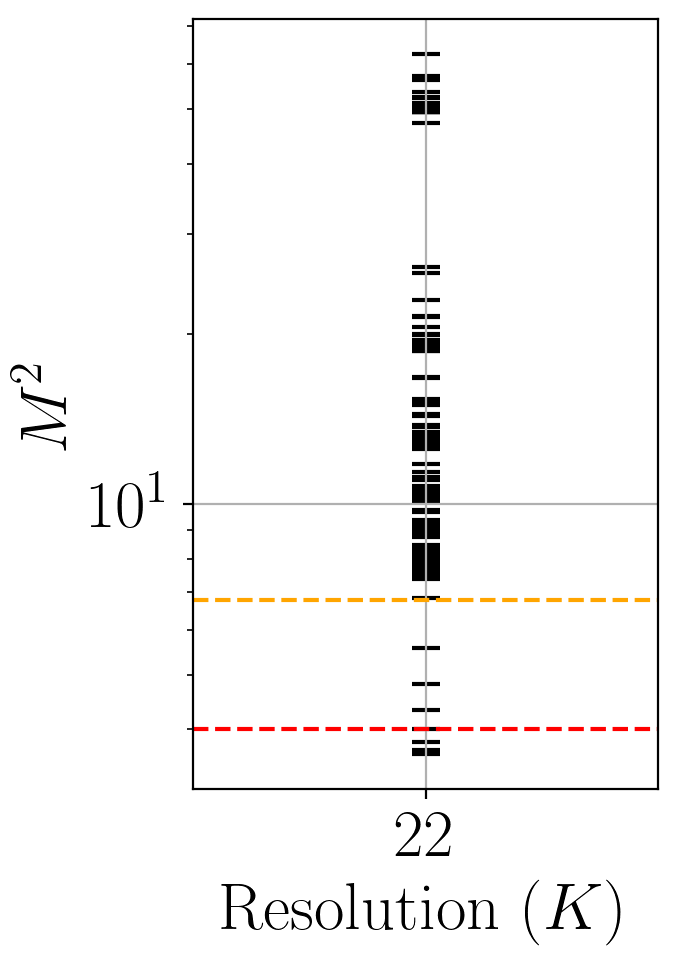

In [589]:
plt.figure(figsize = (3, 5), dpi = 200)
colors = plt.cm.viridis(np.linspace(0, 1, renormalized_eigenvalues.shape[0]))
for i, eig in enumerate(renormalized_eigenvalues):
    plt.scatter(resolutions, (eig), color = 'black', marker='_', s = 100)

plt.xlabel("Resolution ($K$)")
plt.ylabel("$M^2$")

plt.axhline(y = (2 * mf + 0 * mb)**2, color = 'red', linestyle = '--') 
plt.axhline(y = (2 * mf + 1 * mb)**2, color = 'orange', linestyle = '--') 

# plt.title(f'$\log_{{10}}t = {int(np.log10(t))}$,$g = {g}$, $m_f$ = {mf}, $m_b$ = {mb}')
plt.yscale('log')
plt.xticks(resolutions)
plt.grid()

In [597]:
fock_sector_budget(renormalized_eigenvectors[0])

{(0, 0, 0): 0.0, (2, 0, 0): 0.9076493424041587, (2, 0, 1): 0.09235065759584084}

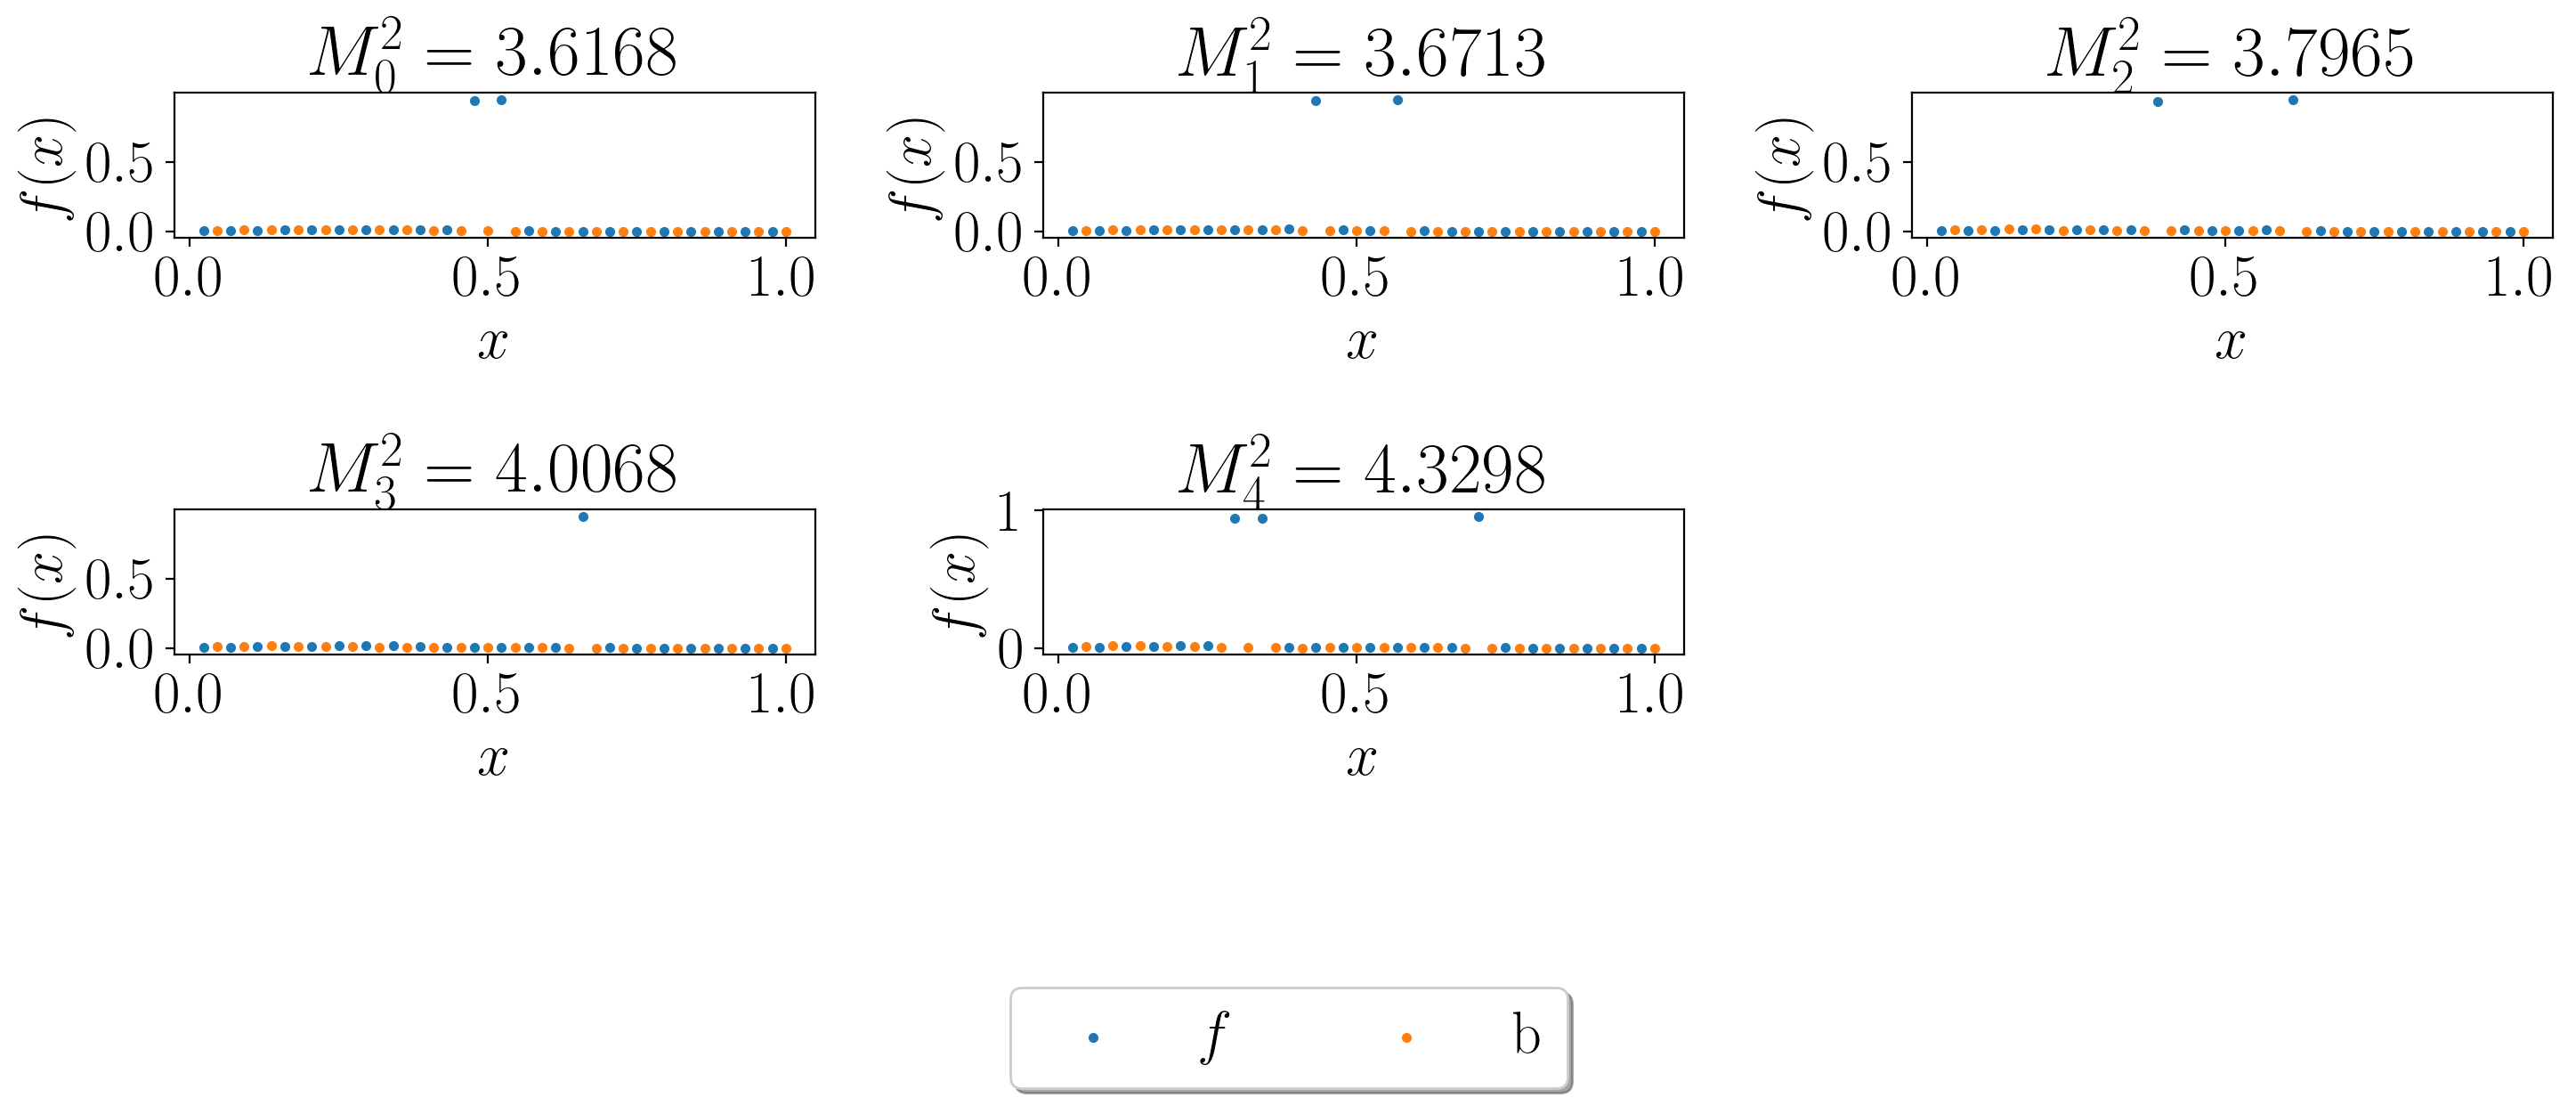

In [591]:
get_pdfs(max_res, renormalized_eigenvalues, renormalized_eigenvectors, 5)

Text(0, 0.5, '$xf(x)$')

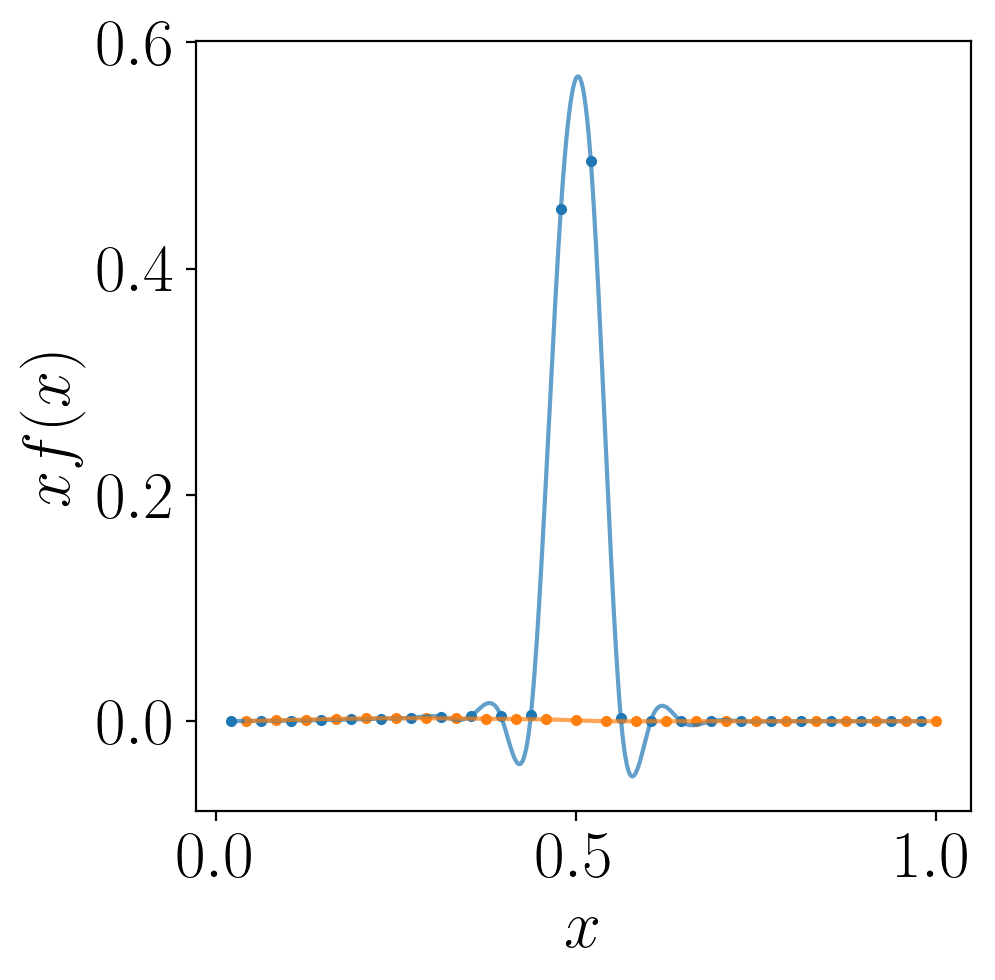

In [346]:
state = 0
psi = renormalized_eigenvectors[state]
res = max_res

x_fermion = np.array([k/res for k in np.arange(1/2, res, 1)])
fermion_pdf = x_fermion* np.real(pdf(res, psi, 'fermion'))

x_boson = np.array([k/res for k in np.arange(1, res + 1, 1)])
boson_pdf = x_boson * np.real(pdf(res, psi, 'boson'))

dx = 0.001
degree = 2

smooth_x_range_fermion = np.arange(min(x_fermion) + dx, max(x_fermion) - dx, dx)
smooth_x_range_boson = np.arange(min(x_boson) + dx, max(x_boson) - dx, dx)

interp_func_fermion = CubicSpline(x_fermion, fermion_pdf)
interp_func_boson = CubicSpline(x_boson, boson_pdf)

smooth_fermion_pdf = interp_func_fermion(smooth_x_range_fermion)
smooth_boson_pdf = interp_func_boson(smooth_x_range_boson)

plt.figure(figsize = (5,5), dpi = 200)


plt.scatter(x_fermion, fermion_pdf, marker = '.', label = r'$f$')
plt.plot(smooth_x_range_fermion, smooth_fermion_pdf, alpha = 0.7)

plt.scatter(x_boson, boson_pdf, marker = '.', label = f'$b$')
plt.plot(smooth_x_range_boson, smooth_boson_pdf, alpha = 0.7)
plt.plot([], [], color = 'white', label = f"$M^2 = {round(renormalized_eigenvalues[state][0], 3)}$")


# plt.legend()
plt.xlabel(f'$x$')
plt.ylabel(f'$xf(x)$')
# plt.savefig("../pdf.pdf")
# plt.ylim(-0.1, 1.1)
# plt.title(f"Yukawa $Q = {baryon_number}$ bound state PDF")
# plt.title(f"$g = {g}, m = {mf}, \mu = {mb}$")

In [58]:
# mf = 1
# mb = 0.5
# g = 1
# t = 1e-7

# resolutions = np.arange(2, 20, 2)
# grounds = []

# for res in resolutions:
#     print("--- K = ", res, " ---")
#     basis = (
#         get_Q_nonzero_sector_basis(resolution=res, n_fermions = 2, n_bosons = 0)
#         + get_Q_nonzero_sector_basis(resolution=res, n_fermions = 2, n_bosons = 1)
#     )
#     hamiltonian = renormalized_yukawa_hamiltonian(
#             res=res, t=t, treg=0, g=g, mf=mf, mb=mb
#         )
#     tmp_mat = generate_matrix_hermitian(hamiltonian, basis)
#     vals = np.linalg.eigvalsh(tmp_mat)
#     grounds.append(min(vals))
    

--- K =  2  ---
--- K =  4  ---
--- K =  6  ---
--- K =  8  ---
--- K =  10  ---
--- K =  12  ---
--- K =  14  ---
--- K =  16  ---
--- K =  18  ---


In [317]:
# fits = []

# for i in range(0, len(grounds) - 2):
#     params = curve_fit(f, resolutions[int(i):], grounds[int(i):])
#     fits.append(f(np.inf, *params[0]))

# plt.plot(range(0, len(grounds) - 2), fits)

In [385]:
g = 0.5
mf = 1
mb = 0.6

resolutions = np.arange(2, 26, 2)

n_bare = []
n_ren = []
for res in resolutions:
    bare = yukawa_hamiltonian(res = res, g = g, mf = mf, mb = mb)
    ren = renormalized_yukawa_hamiltonian(res = res, t = 1e-7, treg = 0, g = g, mf = mf, mb = mb)
    n_bare.append(len(bare))
    n_ren.append(len(ren))



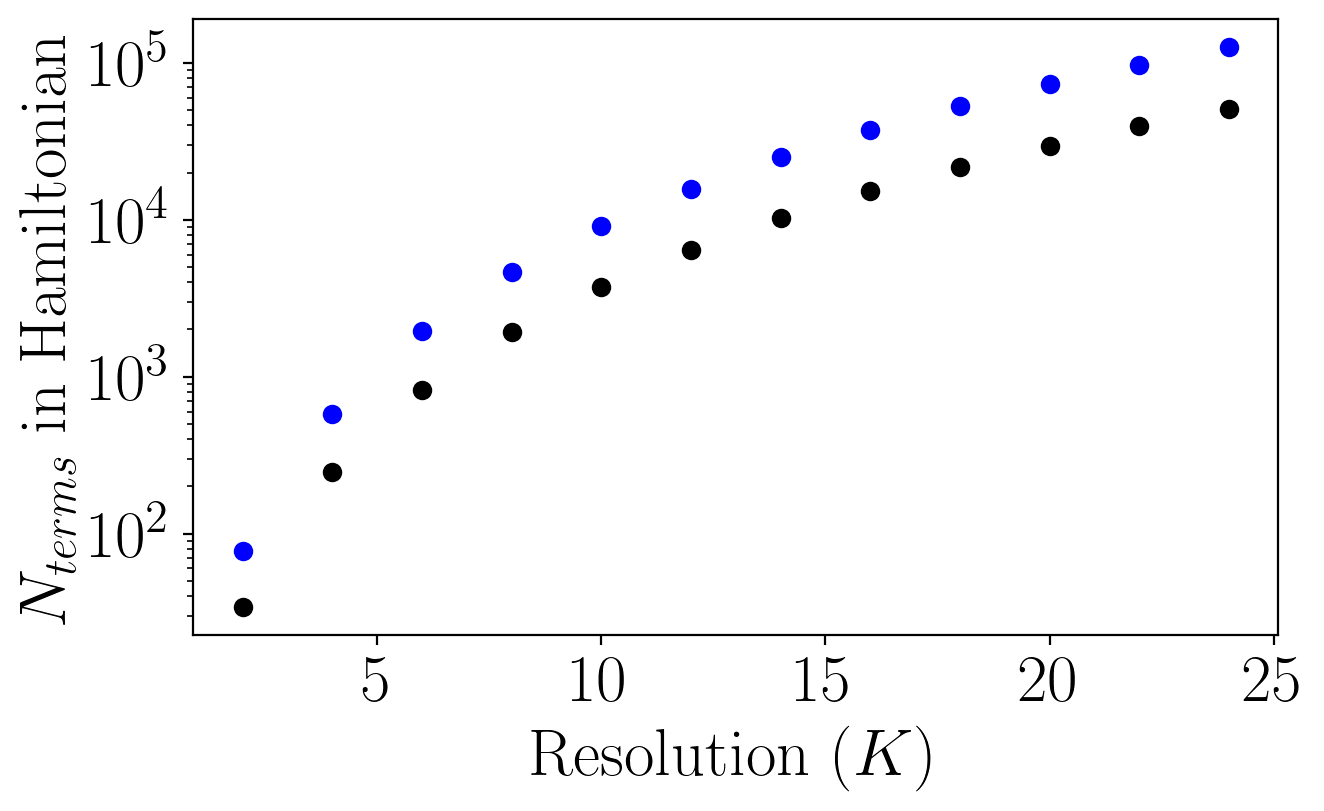

In [394]:
plt.figure(figsize = (7, 4), dpi = 200)

plt.plot(resolutions, n_bare, 'ko', label = 'Bare')
plt.plot(resolutions, n_ren, 'bo', label = 'Renormalized')

plt.xlabel("Resolution ($K$)")
plt.ylabel(r"$N_{terms}$ in Hamiltonian")
plt.yscale('log')
# plt.legend()
# plt.savefig('../n_terms.pdf')